# Text Classification using RNN and RoBERTa

Исходные данные:
https://www.kaggle.com/competitions/nlp-txt-classification

## Library Importations

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import string
import random
import time
import sys
import re
import gc

from tqdm import tqdm
tqdm.pandas()
from bs4 import BeautifulSoup

from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
nltk.download('omw-1.4')
from nltk import word_tokenize
from nltk.tokenize import NLTKWordTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import pos_tag
stopword_list = nltk.corpus.stopwords.words('english')
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.utils.tensorboard import SummaryWriter
import torchtext
from torchtext.data import get_tokenizer
from torchtext.vocab import GloVe

import transformers
from transformers import pipeline
from transformers import AdamW
from transformers import RobertaModel, RobertaTokenizer, RobertaConfig, RobertaForSequenceClassification

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


/kaggle/input/nlp-txt-classification/sample_submission.csv
/kaggle/input/nlp-txt-classification/train.csv
/kaggle/input/nlp-txt-classification/test.csv


In [2]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

BATCH_SIZE = 64
LR_RATE = 0.001

In [3]:
!nvidia-smi

Sun Jan  8 14:14:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Loading Datasets

In [4]:
IN_PATH = '/kaggle/input/'
DATA_PATH = IN_PATH+'nlp-txt-classification/'
OUT_PATH = '/kaggle/working/' # path for output directory

In [5]:
train_df = pd.read_csv(DATA_PATH +'train.csv', index_col = 0)
test_df = pd.read_csv(DATA_PATH +'test.csv', index_col = 0)
sample_submission_df = pd.read_csv(DATA_PATH +'sample_submission.csv', index_col = 0)
print(" Training dataset shape : " + str(train_df.shape))
print(" Testing dataset shape : " + str(test_df.shape))

 Training dataset shape : (41159, 2)
 Testing dataset shape : (3798, 1)


In [6]:
train_df.head()

,Text,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [7]:
test_df.head()

,Text
id,
787bc85b-20d4-46d8-84a0-562a2527f684,TRENDING: New Yorkers encounter empty supermar...
17e934cd-ba94-4d4f-9ac0-ead202abe241,When I couldn't find hand sanitizer at Fred Me...
5914534b-2b0f-4de8-bb8a-e25587697e0d,Find out how you can protect yourself and love...
cdf06cfe-29ae-48ee-ac6d-be448103ba45,#Panic buying hits #NewYork City as anxious sh...
aff63979-0256-4fb9-a2d9-86a3d3ca5470,#toiletpaper #dunnypaper #coronavirus #coronav...


In [8]:
sample_submission_df.head()

,Sentiment
id,
787bc85b-20d4-46d8-84a0-562a2527f684,Neutral
17e934cd-ba94-4d4f-9ac0-ead202abe241,Neutral
5914534b-2b0f-4de8-bb8a-e25587697e0d,Neutral
cdf06cfe-29ae-48ee-ac6d-be448103ba45,Neutral
aff63979-0256-4fb9-a2d9-86a3d3ca5470,Neutral


### Exploratory Data Analysis

In [9]:
train_df.isnull().sum()

Text         1
Sentiment    4
dtype: int64

In [10]:
# Removing blank lines
train_df = train_df[['Text', 'Sentiment']].dropna()

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41155 entries, 0 to 41156
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       41155 non-null  object
 1   Sentiment  41155 non-null  object
dtypes: object(2)
memory usage: 964.6+ KB


In [12]:
temp = train_df.groupby('Sentiment').count()['Text'].reset_index().sort_values(by='Text', ascending=False)
temp.style.background_gradient(cmap='Purples')

,Sentiment,Text
4,Positive,11422
2,Negative,9917
3,Neutral,7711
1,Extremely Positive,6624
0,Extremely Negative,5481


#### Number of characters in text

In [13]:
def length(text):    
    '''a function which returns the length of text'''
    return len(text)
train_df['length_text'] = train_df['Text'].apply(length)

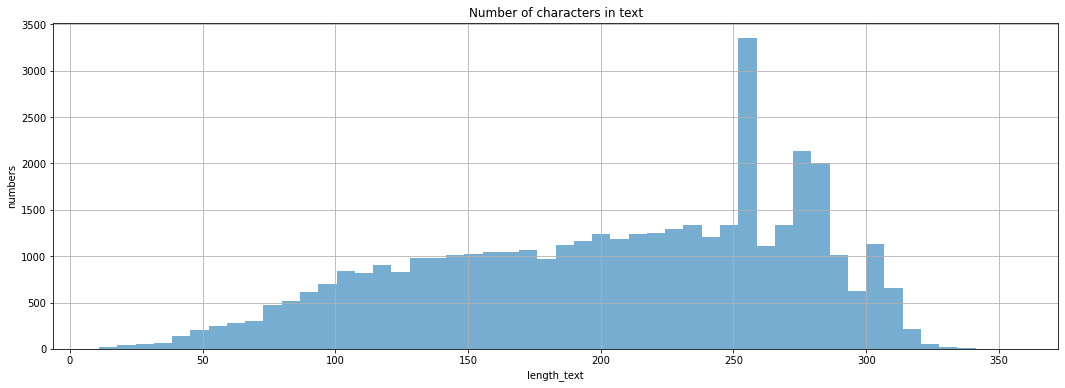

In [14]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 50
plt.hist(train_df['length_text'], alpha = 0.6, bins=bins)
plt.xlabel('length_text')
plt.ylabel('numbers')
plt.title('Number of characters in text')
plt.grid()
plt.show()

#### Number of words in a text

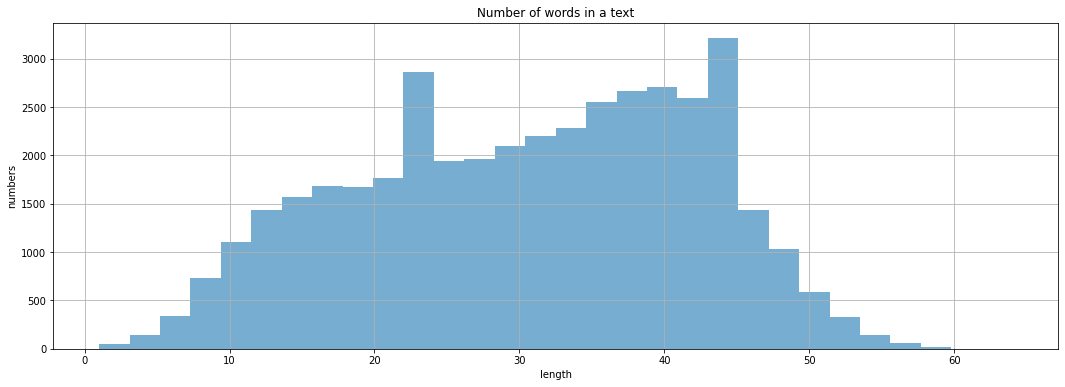

In [15]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 30
text_len=train_df['Text'].str.split().map(lambda x: len(x))
plt.hist(text_len, alpha = 0.6, bins=bins)
plt.xlabel('length')
plt.ylabel('numbers')
plt.title('Number of words in a text')
plt.grid()
plt.show()

### Data Cleaning

In [16]:
# Thanks to https://www.kaggle.com/rftexas/text-only-kfold-bert
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [17]:
# Thanks to https://www.kaggle.com/rftexas/text-only-kfold-bert
def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

In [18]:
# Thanks to https://www.kaggle.com/rftexas/text-only-kfold-bert
def convert_abbrev_in_text(text):
    tokenizer = NLTKWordTokenizer()
    tokens = tokenizer.tokenize(text)
    tokens = [convert_abbrev(word) for word in tokens]
    text = ' '.join(tokens)
    return text

In [19]:
#Removing Emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [20]:
#Removing the stopwords
def remove_stopwords(text):
    tokenizer = NLTKWordTokenizer()
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [21]:
#Removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

In [22]:
#Removing punctuations
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [23]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text) 
    return text

In [24]:
#Removing URL
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [25]:
#Collect all functions
def clean(text):
    text = text.lower() #Lets make it lowercase
    text = remove_URL(text)
    text = remove_emoji(text)
    text = denoise_text(text)
    text = convert_abbrev_in_text(text)
    text = remove_stopwords(text)
    text = remove_punct(text)
    text = remove_special_characters(text)
    return text

In [26]:
train_df['Text_clean'] = train_df['Text'].apply(clean)
test_df['Text_clean'] = test_df['Text'].apply(clean)
train_df.head()

,Text,Sentiment,length_text,Text_clean
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,111,menyrbie philgahan chrisitv
1,advice Talk to your neighbours family to excha...,Positive,237,advice talk neighbours family exchange phone n...
2,Coronavirus Australia: Woolworths to give elde...,Positive,131,coronavirus australia woolworths give elderly...
3,My food stock is not the only one which is emp...,Positive,306,food stock one empty please nt panic enough...
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,310,ready go supermarket covid19 outbreak m para...


In [27]:
#Stemming the text
def simple_stemmer(text):
    ps=SnowballStemmer(language='english')
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

In [28]:
#Lemmatizing the text
def lemmatize_word(text):
    wnl = WordNetLemmatizer()
    text= ' '.join([wnl.lemmatize(word) for word in text.split()])
    return text

In [29]:
train_df['Text_clean_stemmer'] = train_df['Text_clean'].apply(simple_stemmer)
test_df['Text_clean_stemmer'] = test_df['Text_clean'].apply(simple_stemmer)
train_df['Text_clean_lemma'] = train_df['Text_clean'].apply(lemmatize_word)
test_df['Text_clean_lemma'] = test_df['Text_clean'].apply(lemmatize_word)

In [30]:
train_df.head()

,Text,Sentiment,length_text,Text_clean,Text_clean_stemmer,Text_clean_lemma
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,111,menyrbie philgahan chrisitv,menyrbi philgahan chrisitv,menyrbie philgahan chrisitv
1,advice Talk to your neighbours family to excha...,Positive,237,advice talk neighbours family exchange phone n...,advic talk neighbour famili exchang phone numb...,advice talk neighbour family exchange phone nu...
2,Coronavirus Australia: Woolworths to give elde...,Positive,131,coronavirus australia woolworths give elderly...,coronavirus australia woolworth give elder dis...,coronavirus australia woolworth give elderly d...
3,My food stock is not the only one which is emp...,Positive,306,food stock one empty please nt panic enough...,food stock one empti pleas nt panic enough foo...,food stock one empty please nt panic enough fo...
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,310,ready go supermarket covid19 outbreak m para...,readi go supermarket covid19 outbreak m parano...,ready go supermarket covid19 outbreak m parano...


### Encoding the sentiment labels

In [31]:
train_df['Sentiment'].unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

In [32]:
idx_to_sentiment = {k: v for k, v in enumerate(train_df['Sentiment'].unique())}
sentiment_to_idx = {v: k for k, v in idx_to_sentiment.items()}
print(f'Encoded sentiment values: {sentiment_to_idx}')

Encoded sentiment values: {'Neutral': 0, 'Positive': 1, 'Extremely Negative': 2, 'Negative': 3, 'Extremely Positive': 4}


In [33]:
train_df['Label'] = train_df['Sentiment'].apply(lambda x: sentiment_to_idx[x])
train_df['Label'] = train_df['Label'].apply(lambda x: torch.tensor(x))

In [34]:
train_df.head()

,Text,Sentiment,length_text,Text_clean,Text_clean_stemmer,Text_clean_lemma,Label
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,111,menyrbie philgahan chrisitv,menyrbi philgahan chrisitv,menyrbie philgahan chrisitv,tensor(0)
1,advice Talk to your neighbours family to excha...,Positive,237,advice talk neighbours family exchange phone n...,advic talk neighbour famili exchang phone numb...,advice talk neighbour family exchange phone nu...,tensor(1)
2,Coronavirus Australia: Woolworths to give elde...,Positive,131,coronavirus australia woolworths give elderly...,coronavirus australia woolworth give elder dis...,coronavirus australia woolworth give elderly d...,tensor(1)
3,My food stock is not the only one which is emp...,Positive,306,food stock one empty please nt panic enough...,food stock one empti pleas nt panic enough foo...,food stock one empty please nt panic enough fo...,tensor(1)
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,310,ready go supermarket covid19 outbreak m para...,readi go supermarket covid19 outbreak m parano...,ready go supermarket covid19 outbreak m parano...,tensor(2)


In [35]:
test_df.head()

,Text,Text_clean,Text_clean_stemmer,Text_clean_lemma
id,,,,
787bc85b-20d4-46d8-84a0-562a2527f684,TRENDING: New Yorkers encounter empty supermar...,trending new yorkers encounter empty supermar...,trend new yorker encount empti supermarket she...,trending new yorkers encounter empty supermark...
17e934cd-ba94-4d4f-9ac0-ead202abe241,When I couldn't find hand sanitizer at Fred Me...,could nt find hand sanitizer fred meyer turne...,could nt find hand sanit fred meyer turn amazo...,could nt find hand sanitizer fred meyer turned...
5914534b-2b0f-4de8-bb8a-e25587697e0d,Find out how you can protect yourself and love...,find protect loved ones coronavirus,find protect love one coronavirus,find protect loved one coronavirus
cdf06cfe-29ae-48ee-ac6d-be448103ba45,#Panic buying hits #NewYork City as anxious sh...,panic buying hits newyork city anxious shopp...,panic buy hit newyork citi anxious shopper sto...,panic buying hit newyork city anxious shopper ...
aff63979-0256-4fb9-a2d9-86a3d3ca5470,#toiletpaper #dunnypaper #coronavirus #coronav...,toiletpaper dunnypaper coronavirus coronav...,toiletpap dunnypap coronavirus coronavirusaust...,toiletpaper dunnypaper coronavirus coronavirus...


In [36]:
train_df['length_text_clean'] = train_df['Text_clean'].apply(length)

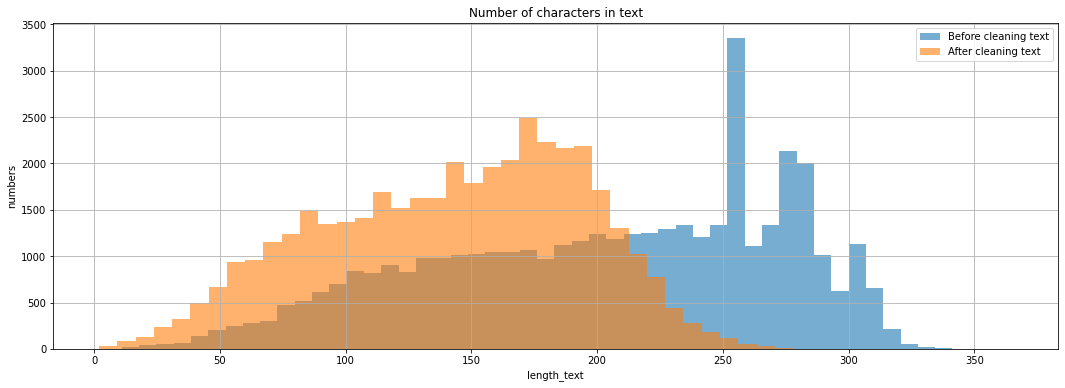

In [37]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 50
plt.hist(train_df['length_text'], alpha = 0.6, bins=bins, label='Before cleaning text')
plt.hist(train_df['length_text_clean'], alpha = 0.6, bins=bins, label='After cleaning text')
plt.xlabel('length_text')
plt.ylabel('numbers')
plt.title('Number of characters in text')
plt.legend(loc='upper right')
plt.grid()
plt.show()

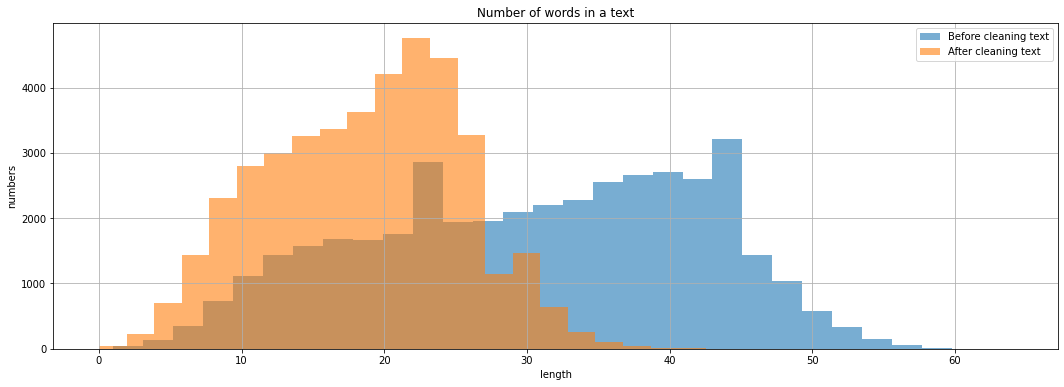

In [38]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 30
text_len=train_df['Text'].str.split().map(lambda x: len(x))
text_len_clean=train_df['Text_clean'].str.split().map(lambda x: len(x))
plt.hist(text_len, alpha = 0.6, bins=bins, label='Before cleaning text')
plt.hist(text_len_clean, alpha = 0.6, bins=bins, label='After cleaning text')
plt.xlabel('length')
plt.ylabel('numbers')
plt.title('Number of words in a text')
plt.legend(loc='upper right')
plt.grid()
plt.show()

In [39]:
#Removing blank lines
train_df = train_df.drop(train_df[train_df['Text_clean'].str.split().map(lambda x: len(x)) == 0].index)
test_df = test_df.drop(test_df[test_df['Text_clean'].str.split().map(lambda x: len(x)) == 0].index)

In [40]:
X_train, X_val, y_train, y_val = train_test_split(train_df.Text_clean, train_df.Label,
                                                  stratify=train_df.Label, 
                                                  test_size=0.2,
                                                  random_state=SEED)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((32916,), (8229,), (32916,), (8229,))

### Bag of words with RNN

In [41]:
#Make vocab
words = [item for sublist in train_df['Text_clean'].str.split()  for item in sublist]
count_words = Counter(words)

total_words = len(words)
sorted_words = count_words.most_common(total_words)
sorted_words[:10], print(f"В словаре {len(sorted_words)} уникальных слов")

В словаре 58668 уникальных слов


([('coronavirus', 18093),
  ('covid19', 16139),
  ('prices', 7934),
  ('food', 7077),
  ('supermarket', 7046),
  ('store', 6839),
  ('grocery', 6245),
  ('people', 5756),
  ('19', 4519),
  ('consumer', 4493)],
 None)

In [42]:
#Delete of names and titles
sorted_words = [(word,count) for (word,count) in sorted_words if count>1]
print(len(sorted_words))

23507


In [43]:
vocab_to_int = {word:i+1 for i, (word, count) in enumerate(sorted_words)}
sorted_words_for_emb = [count for count, i in sorted_words]
MAX_VOCAB_SIZE  = len(sorted_words)

In [44]:
def word_to_int(x):
  text_int = []
  for word in x.split():
    word = vocab_to_int.get(word, 0)
    text_int.append(word)
  return text_int

In [45]:
X_train = X_train.apply(word_to_int)
X_val = X_val.apply(word_to_int)

In [46]:
def pad_features(x, seq_length):
  if len(x)<= seq_length:
    zeroes = np.zeros(seq_length-len(x))
    new = np.concatenate([zeroes,np.array(x)]) #zeroes+np.array(x)
  else:
    new = np.array(x[0:seq_length])
  return new

In [47]:
X_train = X_train.apply(pad_features, seq_length = 45)
X_val = X_val.apply(pad_features, seq_length = 45)

## DataLoader, Dataset

In [48]:
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.long), torch.from_numpy(y_train.values.astype(np.int64)))
valid_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.long), torch.from_numpy(y_val.values.astype(np.int64)))

In [49]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size = BATCH_SIZE)
valid_loader = DataLoader(valid_dataset, shuffle=True, batch_size = BATCH_SIZE)

In [50]:
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

In [51]:
print('Sample input size', sample_x.size())
print('Sample input: \n', sample_x)
print('Sample label size', sample_y.size())
print('Sample label: \n', sample_y)

Sample input size torch.Size([64, 45])
Sample input: 
 tensor([[    0,     0,     0,  ...,  3061,     0,   929],
        [    0,     0,     0,  ...,  1204,    50,   688],
        [    0,     0,     0,  ...,     9,     1, 16000],
        ...,
        [    0,     0,     0,  ...,  1368,     1,  3118],
        [    0,     0,     0,  ...,    46,  1433, 16317],
        [    0,     0,     0,  ..., 21099,    24,    24]])
Sample label size torch.Size([64])
Sample label: 
 tensor([1, 4, 4, 4, 3, 4, 4, 4, 0, 0, 2, 3, 2, 2, 1, 3, 3, 3, 0, 4, 4, 4, 3, 1,
        0, 3, 3, 4, 3, 3, 4, 3, 0, 4, 1, 1, 4, 3, 0, 2, 1, 0, 1, 3, 4, 3, 3, 0,
        3, 1, 1, 3, 1, 1, 1, 0, 3, 2, 1, 1, 3, 1, 1, 3])


### Build model

In [52]:
class RNN(nn.Module):
    def __init__(self, input_dim, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout_rate):
        super().__init__()

        self.emb_dim = input_dim

        self.output_dim = output_dim
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.dropout_rate = dropout_rate

        self.embedding = nn.Embedding(vocab_size, embedding_dim) 
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first = True) 
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, features): 

        embedds = self.embedding(features)
        embedds = self.dropout(embedds)

        output, (h_n, c_n) = self.lstm(embedds)
        output = self.fc(h_n[-1])
        return output

In [53]:
MAX_VOCAB_SIZE = len(sorted_words)
MAX_VOCAB_SIZE

23507

In [54]:
INPUT_DIM = 45
VOCAB_SIZE = MAX_VOCAB_SIZE+1
EMBEDDING_DIM = 50
HIDDEN_DIM = 256
OUTPUT_DIM = 5
N_LAYERS = 3
DROPOUT = 0.1

model = RNN(INPUT_DIM, 
            VOCAB_SIZE,
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            DROPOUT) 

In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.SGD(model.parameters(), lr=LR_RATE)
lr_scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1,step_size_up=5,mode="exp_range",gamma=0.85)

In [56]:
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [57]:
def accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    correct = (preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [58]:
def train(model, iterator, optimizer, scheduler, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for feature, label in iterator:
        feature, label = feature.to(device), label.to(device)
        optimizer.zero_grad()
        
        predictions = model(feature)  
        loss = criterion(predictions, label)
        
        predictions = torch.softmax(predictions, dim=1)
        predictions=torch.argmax(predictions, dim=1)
        
        acc = accuracy(predictions, label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    scheduler.step()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [59]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for feature, label in iterator:
            feature, label = feature.to(device), label.to(device)

            predictions = model(feature)
            loss = criterion(predictions,label)
            
            predictions = torch.softmax(predictions, dim=1)
            predictions=torch.argmax(predictions, dim=1)            
            
            acc = accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [60]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [61]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf /kaggle/working/runs
!mkdir /kaggle/working/runs

In [62]:
writer = SummaryWriter('runs/RNN+BoW')
N_EPOCHS = 20

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_loader, optimizer, lr_scheduler, criterion)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion)
      
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-model.pt')
    
    writer.add_scalar("Train Loss", train_loss, epoch+1)
    writer.add_scalar("Train Acc", train_acc, epoch+1)
    writer.add_scalar("Valid Loss", valid_loss, epoch+1)
    writer.add_scalar("Valid Acc", valid_acc, epoch+1)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 7s
	Train Loss: 1.585 | Train Acc: 27.62%
	 Val. Loss: 1.576 |  Val. Acc: 27.77%
Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 1.572 | Train Acc: 27.97%
	 Val. Loss: 1.552 |  Val. Acc: 29.49%
Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 1.513 | Train Acc: 30.78%
	 Val. Loss: 1.505 |  Val. Acc: 31.61%
Epoch: 04 | Epoch Time: 0m 6s
	Train Loss: 1.505 | Train Acc: 31.41%
	 Val. Loss: 1.499 |  Val. Acc: 32.06%
Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 1.487 | Train Acc: 32.90%
	 Val. Loss: 1.477 |  Val. Acc: 33.22%
Epoch: 06 | Epoch Time: 0m 5s
	Train Loss: 1.462 | Train Acc: 34.28%
	 Val. Loss: 1.439 |  Val. Acc: 35.62%
Epoch: 07 | Epoch Time: 0m 6s
	Train Loss: 1.405 | Train Acc: 37.42%
	 Val. Loss: 1.370 |  Val. Acc: 40.51%
Epoch: 08 | Epoch Time: 0m 5s
	Train Loss: 1.345 | Train Acc: 40.81%
	 Val. Loss: 1.321 |  Val. Acc: 42.37%
Epoch: 09 | Epoch Time: 0m 6s
	Train Loss: 1.289 | Train Acc: 44.19%
	 Val. Loss: 1.277 |  Val. Acc: 45.30%
Epoch: 10 | Epoch Time: 0m 6

In [63]:
writer.close()

### Pretrained embedding (GloVe) with RNN

In [64]:
#Download GloVe embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
!ls -lat

--2023-01-08 14:17:03--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-01-08 14:17:04--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-01-08 14:17:05--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [65]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')

In [66]:
def get_emb_matrix(EMBEDDING_FILE, EMBEDDING_DIM):
    emb_mean,emb_std = -0.005838499,0.48782197
    embedding_matrix = np.random.normal(emb_mean,emb_std, size=(VOCAB_SIZE, EMBEDDING_DIM))
    embeddings_index  = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    for k, v in vocab_to_int.items():
        if v >= VOCAB_SIZE: continue
        embedding_vector = embeddings_index.get(k)
        if embedding_vector is not None:
            embedding_matrix[v] = embedding_vector
    return embedding_matrix

In [67]:
VOCAB_SIZE = MAX_VOCAB_SIZE+1
VOCAB_SIZE

23508

In [68]:
embedding_matrix300 = get_emb_matrix('glove.6B.300d.txt', 300)
embedding_matrix200 = get_emb_matrix('glove.6B.200d.txt', 200)

In [69]:
class BiRNN(nn.Module):
    def __init__(self, input_dim, vocab_size, embedding_matrix, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout_rate): #vocab_size, , pad_index , pad_index
        # super(RNN, self).__init__() , bidirectional,                 dropout_rate)
        super().__init__()

        self.emb_dim = input_dim

        self.output_dim = output_dim
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.dropout = dropout_rate

        self.embedding_matrix = embedding_matrix
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False) 

        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, bidirectional=bidirectional, dropout=dropout_rate,batch_first = True) #, dropout=dropout_rate, batch_first=False
        # self.fc = nn.Linear(hidden_dim*2  if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)#.double()
        # self.hidden_dim_l = (hidden_dim*2  if bidirectional else hidden_dim)

        self.model1 = nn.Sequential(
            nn.Linear((hidden_dim*2  if bidirectional else hidden_dim), int((hidden_dim*2  if bidirectional else hidden_dim)/2)),
            nn.BatchNorm1d(int((hidden_dim*2  if bidirectional else hidden_dim)/2)),
            nn.ReLU()
        )
        self.model2 = nn.Sequential(
            nn.Linear(int((hidden_dim*2  if bidirectional else hidden_dim)/2), int((hidden_dim*2  if bidirectional else hidden_dim)/4)),
            nn.BatchNorm1d(int((hidden_dim*2  if bidirectional else hidden_dim)/4)),
            nn.ReLU()
        )        
        self.model3 = nn.Sequential(
            nn.Linear(int((hidden_dim*2  if bidirectional else hidden_dim)/4), int((hidden_dim*2  if bidirectional else hidden_dim)/8)),
            nn.BatchNorm1d(int((hidden_dim*2  if bidirectional else hidden_dim)/8)),
            nn.ReLU()
        )        
        self.model4 = nn.Sequential(
            nn.Linear(int((hidden_dim*2  if bidirectional else hidden_dim)/8), int((hidden_dim*2  if bidirectional else hidden_dim)/16)),
            nn.BatchNorm1d(int((hidden_dim*2  if bidirectional else hidden_dim)/16)),
            nn.ReLU())
        self.model5 = nn.Sequential(
            nn.Linear(int((hidden_dim*2  if bidirectional else hidden_dim)/16), int((hidden_dim*2  if bidirectional else hidden_dim)/32)),
            nn.BatchNorm1d(int((hidden_dim*2  if bidirectional else hidden_dim)/32)),
            nn.ReLU())
        self.model6 = nn.Sequential(
            nn.Linear(int((hidden_dim*2  if bidirectional else hidden_dim)/32), int((hidden_dim*2  if bidirectional else hidden_dim)/64)),
            nn.BatchNorm1d(int((hidden_dim*2  if bidirectional else hidden_dim)/64)),
            nn.ReLU())
        self.fc7 = nn.Linear(int((hidden_dim*2  if bidirectional else hidden_dim)/64), output_dim)
    def forward(self, features): #, lengths
        # print(features.shape)
        embedds = self.embedding(features)
        # print(embedds.shape)
        # embedds = nn.ZeroPad2d(embedds, self.pad_index)
        embedds = self.dropout(embedds)

        output, (h_n, c_n) = self.lstm(embedds)
        # print('h_n.shape', h_n.shape, h_n[-1].shape)
        # output.squeeze_(0)
        if self.lstm.bidirectional:
            h_n = self.dropout(torch.cat([h_n[-1,:,:], h_n[-2,:,:]], dim=-1))

        else:
            h_n = self.dropout(h_n[-1,:,:])
        # output = self.model1(self.dropout(h_n))
        output = self.model1(h_n)
        output = self.model2(output)
        output = self.model3(output)
        output = self.model4(output)
        output = self.model5(output)
        output = self.model6(output)
        output = self.fc7(output)
        return output

In [70]:
INPUT_DIM = 45
VOCAB_SIZE = MAX_VOCAB_SIZE+1
EMBEDDING_MATRIX = torch.tensor(embedding_matrix200, dtype=torch.float32)
EMBEDDING_DIM = 200
HIDDEN_DIM = 512
OUTPUT_DIM = 5
N_LAYERS = 3
BIDIRECTIONAL = True
DROPOUT = 0.1
VEC_DIM = 200

model = BiRNN(INPUT_DIM, 
            VOCAB_SIZE,
            EMBEDDING_MATRIX,
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT) 

In [71]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.SGD(model.parameters(), lr=LR_RATE)
lr_scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1,step_size_up=5,mode="exp_range",gamma=0.85)

In [72]:
criterion = nn.CrossEntropyLoss()
model = model.to(device)
criterion = criterion.to(device)

In [73]:
writer = SummaryWriter('runs/RNN+EMB')
N_EPOCHS = 20

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss, train_acc = train(model, train_loader, optimizer, lr_scheduler, criterion)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion)
        
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
      
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-model.pt')
      
    writer.add_scalar("Train Loss", train_loss, epoch+1)
    writer.add_scalar("Train Acc", train_acc, epoch+1)
    writer.add_scalar("Valid Loss", valid_loss, epoch+1)
    writer.add_scalar("Valid Acc", valid_acc, epoch+1)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 39s
	Train Loss: 1.571 | Train Acc: 26.32%
	 Val. Loss: 1.517 |  Val. Acc: 31.30%
Epoch: 02 | Epoch Time: 0m 39s
	Train Loss: 1.346 | Train Acc: 40.54%
	 Val. Loss: 1.215 |  Val. Acc: 46.93%
Epoch: 03 | Epoch Time: 0m 39s
	Train Loss: 1.222 | Train Acc: 47.81%
	 Val. Loss: 1.236 |  Val. Acc: 47.86%
Epoch: 04 | Epoch Time: 0m 39s
	Train Loss: 1.120 | Train Acc: 52.90%
	 Val. Loss: 1.102 |  Val. Acc: 53.84%
Epoch: 05 | Epoch Time: 0m 39s
	Train Loss: 1.009 | Train Acc: 58.81%
	 Val. Loss: 0.997 |  Val. Acc: 59.19%
Epoch: 06 | Epoch Time: 0m 39s
	Train Loss: 0.924 | Train Acc: 63.49%
	 Val. Loss: 1.151 |  Val. Acc: 48.64%
Epoch: 07 | Epoch Time: 0m 39s
	Train Loss: 0.856 | Train Acc: 67.04%
	 Val. Loss: 0.828 |  Val. Acc: 68.50%
Epoch: 08 | Epoch Time: 0m 39s
	Train Loss: 0.806 | Train Acc: 69.66%
	 Val. Loss: 0.847 |  Val. Acc: 67.33%
Epoch: 09 | Epoch Time: 0m 39s
	Train Loss: 0.774 | Train Acc: 71.18%
	 Val. Loss: 0.774 |  Val. Acc: 71.16%
Epoch: 10 | Epoch T

In [74]:
writer.close()

### RoBERTa

In [75]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [76]:
def get_tokens(text: str):
    encoded_dict = tokenizer.encode_plus(text,
                                         add_special_tokens=True,
                                         truncation=True,
                                         max_length=128,
                                         padding='max_length',
                                         return_attention_mask=True,
                                         return_tensors='pt')
    input_ids = encoded_dict['input_ids'].squeeze(0)
    attention_mask = encoded_dict['attention_mask'].squeeze(0)
    return input_ids, attention_mask

In [77]:
train_df['input_ids'], train_df['attention_mask'] = zip(*train_df['Text_clean'].progress_apply(get_tokens))

100%|██████████| 41145/41145 [00:20<00:00, 1968.25it/s]


In [78]:
class TextDataset(torch.utils.data.Dataset):
    """
    Class to create PyTorch dataset for the sentiment analysis task
    """

    def __init__(self, data_df: pd.DataFrame):
        """
        Create the PyTorch dataset for the sentiment analysis task
        Parameters
        ----------
        data_df (pd.DataFrame): prepared data in Pandas DataFrame format
        """

        self.data_df = data_df

    def __len__(self):
        """
        Returns
        ----------
        data_len (int): dataset length
        """
        data_len = self.data_df.shape[0]
        return data_len

    def __getitem__(self, idx: int):
        """
        Gets tokenized text, attention masks and labels by id
        
        Parameters
        ----------
        idx (int): data item id
        
        Returns
        ----------
        input_ids (torch.Tensor): tokenized text
        attention_mask (torch.Tensor): attention mask
        label (torch.Tensor): sentiment label
        """
        input_ids = self.data_df.iloc[idx]['input_ids']
        attention_mask = self.data_df.iloc[idx]['attention_mask']
        label = self.data_df.iloc[idx]['Label']
        return input_ids, attention_mask, label

In [79]:
train_split, val_split = train_test_split(train_df,
                                          stratify=train_df.Label, 
                                          test_size=0.2,
                                          random_state=SEED)
train_split.shape, val_split.shape

((32916, 10), (8229, 10))

In [80]:
train_dataset = TextDataset(train_split)
train_loader = DataLoader(train_dataset,
                          shuffle=True,
                          batch_size=32,
                          drop_last=True)

val_dataset = TextDataset(val_split)
val_loader = DataLoader(val_dataset,
                        shuffle=False,
                        batch_size=32,
                        drop_last=False)

In [81]:
model = RobertaForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-emotion",
                                                      num_labels=len(sentiment_to_idx),
                                                      output_attentions=False,
                                                      output_hidden_states=False,
                                                      ignore_mismatched_sizes=True)

Downloading:   0%|          | 0.00/768 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [82]:
epochs = 8
optimizer = optim.SGD(model.parameters(), lr=LR_RATE)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1,step_size_up=5,mode="exp_range",gamma=0.85)

In [83]:
class RunningAverage:
    """
    Class to save and update the running average
    """

    def __init__(self) -> None:
        self.count = 0
        self.total = 0.0

    def update(self, n: float) -> None:
        """
        Updates running average with new value
        Parameters
        ----------
        n (float): value to add to the running average
        """
        self.total += n
        self.count += 1

    def __call__(self) -> float:
        """
        Returns current running average
        Returns
        -------
        running_avg (float): Current running average
        """
        running_avg = self.total / (self.count + 1e-15)
        return running_avg

In [84]:
device = torch.device('cuda')
model.to(device)

for e in range(epochs):
    loss_avg = RunningAverage()
    val_avg = RunningAverage()
    val_loss_avg = RunningAverage()

    # Force the garbage collection
    torch.cuda.empty_cache()
    gc.collect()

    model.train()
    with tqdm(total=len(train_loader), leave=False, file=sys.stdout) as t:
        t.set_description(f'Epoch {e + 1}')

        for batch_n, batch_data in enumerate(train_loader):
            # Load the current batch data on the defined device
            b_input_ids = batch_data[0].to(device)
            b_input_mask = batch_data[1].to(device)
            b_labels = batch_data[2].to(device)

            model.zero_grad()
            model_output = model(b_input_ids,
                                 token_type_ids=None,
                                 attention_mask=b_input_mask,
                                 labels=b_labels)
            loss, logits = model_output['loss'], model_output['logits']
            loss_avg.update(loss.item())
            loss.backward()
            # Adaptively clip gradients to avoid gradient explosion
            torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
            optimizer.step()
            # Update the LR scheduler every step
            scheduler.step()

            t.set_postfix({'stats': f'train_loss: {loss_avg():.4f}'})
            t.update()
            stats_time_elapsed = t.format_interval(t.format_dict['elapsed'])

    # Evaluate every epoch
    model.eval()
    with torch.no_grad():
        for val_batch_data in val_loader:
            # Load the current batch data on the defined device
            b_val_input_ids = val_batch_data[0].to(device)
            b_val_input_mask = val_batch_data[1].to(device)
            b_val_labels = val_batch_data[2].to(device)

            val_model_output = model(b_val_input_ids,
                                     token_type_ids=None,
                                     attention_mask=b_val_input_mask,
                                     labels=b_val_labels)
            val_loss, val_logits = val_model_output['loss'], val_model_output['logits']
            val_loss_avg.update(val_loss.item())
            val_logits = torch.argmax(val_logits, 1)
            # Calculate the validation accuracy
            val_batch = torch.sum(val_logits == b_val_labels) / b_val_labels.shape[0]
            val_avg.update(val_batch.item())

    # Print the epoch stats
    print(f'Epoch {e + 1}. Train_loss: {loss_avg():.4f},'
          f' val_loss: {val_loss_avg():.4f}, val: {val_avg():.4f}, time: {stats_time_elapsed}')

Epoch 1. Train_loss: 1.3881, val_loss: 1.1289, val: 0.5164, time: 06:26
Epoch 2. Train_loss: 1.0184, val_loss: 0.8965, val: 0.6449, time: 06:26
Epoch 3. Train_loss: 0.9101, val_loss: 0.8855, val: 0.6548, time: 06:26
Epoch 4. Train_loss: 0.8434, val_loss: 0.8850, val: 0.6553, time: 06:26
Epoch 5. Train_loss: 0.8013, val_loss: 0.8004, val: 0.7026, time: 06:27
Epoch 6. Train_loss: 0.7695, val_loss: 0.8300, val: 0.6813, time: 06:27
Epoch 7. Train_loss: 0.7336, val_loss: 0.7484, val: 0.7295, time: 06:28
Epoch 8. Train_loss: 0.7125, val_loss: 0.8024, val: 0.7001, time: 06:27


In [85]:
sentiments = []

model.eval()
with torch.inference_mode():
    for i, row in tqdm(test_df.iterrows(), total=test_df.shape[0]):
        # Cleanup and tokenize the sentence
        text = row['Text_clean']
        input_ids, attention_mask = get_tokens(text)
        # Place the tokenized sentence and its attention mask tensors on defined device
        input_ids, attention_mask = input_ids.unsqueeze(0).to(device), attention_mask.unsqueeze(0).to(device)
        # Get predictions
        logits = model(input_ids,
                       attention_mask=attention_mask,
                       labels=None)['logits']
        pred = torch.argmax(logits, 1)
        # Convert the integer category value to its actual name and save in predictions list
        sentiments.append(idx_to_sentiment[pred.item()])

# Save the predictions in Pandas column
test_df['Sentiment'] = sentiments

100%|██████████| 3798/3798 [00:27<00:00, 137.67it/s]


In [86]:
submission = test_df['Sentiment']
submission.to_csv('submission_8_Roberta.csv', index=True)

In [87]:
# ! kaggle competitions submit -c nlp-txt-classification -f submission_4.csv -m "4 Roberta EPOCH"

In [88]:
%tensorboard --logdir={./runs/}